<a href="https://colab.research.google.com/github/toshif/colab1/blob/main/jax_lstm_simple_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/deepmind/dm-haiku/blob/main/examples/haiku_lstms.ipynb

In [4]:
!pip install git+https://github.com/deepmind/dm-haiku

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-41_dkxlr
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-41_dkxlr


In [5]:
!pip install optax

In [6]:
import functools
import math
from typing import Tuple, TypeVar
import warnings

import haiku as hk
import jax
import jax.numpy as jnp
import optax
import numpy as np
import pandas as pd
import plotnine as gg

T = TypeVar('T')
Pair = Tuple[T, T]

gg.theme_set(gg.theme_bw())
warnings.filterwarnings('ignore')

In this notebook, we generate many sine waves (of the same period), and try to predict the next value in the wave based on its previous values.

For simplicity, we generate static-sized datasets and wrap them with an iterator-based API.

In [9]:
def sine_seq(
    train_num: int,
    val_num: int
) -> Pair[np.ndarray]:
  """Returns x, y in [T, B] tensor."""
  channels = 2
  x = np.random.rand(4, train_num + val_num, channels)
  y = x[:2, :, -1:] * 10
  return x, y

x, y = sine_seq(7, 3)
print(f'x={x.shape}, y={y.shape}')
del x, y

x=(4, 10, 2), y=(2, 10, 1)


In [10]:
def generate_data(
    train_size: int,
    valid_size: int,
) -> Pair[Pair[np.ndarray]]:
  all_x, all_y = sine_seq(train_size, valid_size)

  train_x = all_x[:, :train_size]
  train_y = all_y[:, :train_size]

  valid_x = all_x[:, train_size:]
  valid_y = all_y[:, train_size:]

  return (train_x, train_y), (valid_x, valid_y)


class Dataset:
  """An iterator over a numpy array, revealing batch_size elements at a time."""

  def __init__(self, xy: Pair[np.ndarray], batch_size: int):
    self._x, self._y = xy
    self._batch_size = batch_size
    self._length = self._x.shape[1]
    self._idx = 0
    if self._length % batch_size != 0:
      msg = 'dataset size {} must be divisible by batch_size {}.'
      raise ValueError(msg.format(self._length, batch_size))

  def __next__(self) -> Pair[np.ndarray]:
    start = self._idx
    end = start + self._batch_size
    x, y = self._x[:, start:end], self._y[:, start:end]
    if end >= self._length:
      end = end % self._length
      assert end == 0  # Guaranteed by ctor assertion.
    self._idx = end

    # tmp for MLP
    x = np.transpose(x, axes=(1, 0, 2))
    y = np.transpose(y, axes=(1, 0, 2))
    y = y.reshape(y.shape[0], -1)

    return x, y


tr1, val1 = generate_data(20, 8)
print(f'train shape x={tr1[0].shape}, y={tr1[1].shape}')
print(f'val1 shape x={val1[0].shape}, y={val1[1].shape}')

train_ds1 = Dataset(tr1, 4)
train_ds1_sample = next(train_ds1)
print(f'train_ds1_sample x={train_ds1_sample[0].shape}, y={train_ds1_sample[1].shape}')
del tr1, val1, train_ds1, train_ds1_sample

train shape x=(4, 20, 2), y=(2, 20, 1)
val1 shape x=(4, 8, 2), y=(2, 8, 1)
train_ds1_sample x=(4, 4, 2), y=(4, 2)


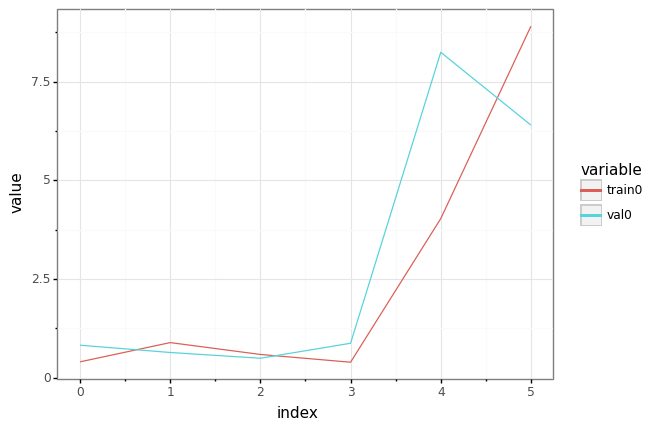

In [14]:
TRAIN_SIZE = 2 ** 14
VALID_SIZE = 128
BATCH_SIZE = 8
SEQ_LEN = 64

train, valid = generate_data(TRAIN_SIZE, VALID_SIZE)

# Plot an observation/target pair.
df = pd.DataFrame({'train0': np.append(train[0][:, 0, 1], train[1][:, 0, 0]), 
                   'val0': np.append(valid[0][:, 0, 1], valid[1][:, 0, 0])}).reset_index()
df = pd.melt(df, id_vars=['index'], value_vars=['train0', 'val0'])
plot = gg.ggplot(df) + gg.aes(x='index', y='value', color='variable') + gg.geom_line()
plot.draw()

train_ds = Dataset(train, BATCH_SIZE)
valid_ds = Dataset(valid, BATCH_SIZE)
del train, valid  # Don't leak temporaries.

##Training an LSTM

To train the LSTM, we define a Haiku function which unrolls the LSTM over the input sequence, generating predictions for all output values. The LSTM always starts with its initial state at the start of the sequence.

The Haiku function is then transformed into a pure function through hk.transform, and is trained with Adam on an L2 prediction loss.

In [17]:
def unroll_net(seqs: jnp.ndarray):
  """Unrolls an LSTM over seqs, mapping each output to a scalar."""
  # seqs is [T, B, F].
  # T is the number of time steps.
  # B batch size
  # F features
  core = hk.LSTM(32)
  batch_size = seqs.shape[1]
  outs, state = hk.dynamic_unroll(core, seqs, core.initial_state(batch_size))
  # We could include this Linear as part of the recurrent core!
  # However, it's more efficient on modern accelerators to run the linear once
  # over the entire sequence than once per sequence element.
  return hk.BatchApply(hk.Linear(1))(outs), state


def net_fn(x) -> jnp.ndarray:
  """https://github.com/deepmind/dm-haiku/blob/main/examples/mnist.py#L30
  """
  mlp = hk.Sequential([
      hk.Flatten(),
      hk.Linear(4), jax.nn.relu,
      hk.Linear(2)
  ])
  return mlp(x)

# model = hk.transform(unroll_net)
model = hk.transform(net_fn)

def train_model(train_ds: Dataset, valid_ds: Dataset) -> hk.Params:
  """Initializes and trains a model on train_ds, returning the final params."""
  rng = jax.random.PRNGKey(428)
  opt = optax.adam(1e-3)

  @jax.jit
  def loss(params, x, y):
    pred = model.apply(params, None, x)
    return jnp.mean(jnp.square(pred - y))

  @jax.jit
  def update(step, params, opt_state, x, y):
    l, grads = jax.value_and_grad(loss)(params, x, y)
    grads, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, grads)
    return l, params, opt_state

  # Initialize state.
  sample_x, _ = next(train_ds)
  params = model.init(rng, sample_x)
  opt_state = opt.init(params)

  for step in range(20001):
    if step % 1000 == 0:
      x, y = next(valid_ds)
      print("Step {}: valid loss {}".format(step, loss(params, x, y)))

    x, y = next(train_ds)
    train_loss, params, opt_state = update(step, params, opt_state, x, y)
    if step % 1000 == 0:
      print("Step {}: train loss {}".format(step, train_loss))

  return params

In [18]:
trained_params = train_model(train_ds, valid_ds)

Step 0: valid loss 45.296871185302734
Step 0: train loss 43.58987808227539
Step 1000: valid loss 9.762608528137207
Step 1000: train loss 9.76577091217041
Step 2000: valid loss 2.9613349437713623
Step 2000: train loss 2.260577440261841
Step 3000: valid loss 0.5105446577072144
Step 3000: train loss 0.27177703380584717
Step 4000: valid loss 0.10699909925460815
Step 4000: train loss 0.048330724239349365
Step 5000: valid loss 0.007189274299889803
Step 5000: train loss 0.006919306702911854
Step 6000: valid loss 0.00014905931311659515
Step 6000: train loss 0.02068115770816803
Step 7000: valid loss 3.3792253816500306e-05
Step 7000: train loss 2.1875639504287392e-05
Step 8000: valid loss 5.23436665389454e-06
Step 8000: train loss 6.846877113275696e-06
Step 9000: valid loss 2.194813896494452e-05
Step 9000: train loss 3.005073631356936e-05
Step 10000: valid loss 2.799320668600558e-07
Step 10000: train loss 7.607681027366198e-07
Step 11000: valid loss 6.987436904637434e-07
Step 11000: train loss 8

## Sampling

The point of training models is so that they can make predictions! How can we generate predictions with the trained model?

If we're allowed to feed in the ground truth, we can just run the original model's apply function.

In [19]:
def plot_samples(truth: np.ndarray, prediction: np.ndarray) -> gg.ggplot:
  assert truth.shape == prediction.shape
  df = pd.DataFrame({'truth': truth.squeeze(), 'predicted': prediction.squeeze()}).reset_index()
  df = pd.melt(df, id_vars=['index'], value_vars=['truth', 'predicted'])
  plot = (
      gg.ggplot(df)
      + gg.aes(x='index', y='value', color='variable')
      + gg.geom_line()
  )
  return plot

sample_x=[[[0.16180244 0.32894737]
  [0.20525675 0.00495722]
  [0.08904051 0.55257736]
  [0.49784389 0.09668387]]]
truth_y=[[3.28947372 0.04957219]]
predicted=[[3.2894702  0.04957116]]


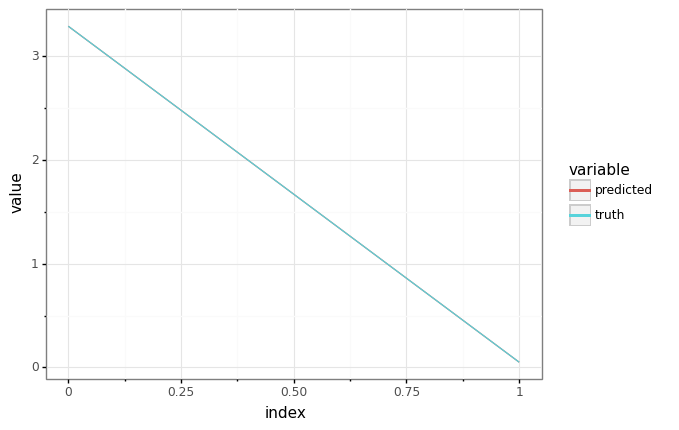

In [22]:
# Grab a sample from the validation set.
sample_x, sample_y = next(valid_ds)
sample_x = sample_x[:1, :]  # Shrink to batch-size 1.
truth_y = sample_y[:1, :]


# Generate a prediction, feeding in ground truth at each point as input.
predicted = model.apply(trained_params, None, sample_x)

print(f'sample_x={sample_x}')
print(f'truth_y={truth_y}')
print(f'predicted={predicted}')

# print(f'predicted shape={predicted.shape}')
# print(f'truth_y shape={truth_y.shape}')

plot = plot_samples(truth_y, predicted)
plot.draw()
del sample_x, predicted

# Typically: the beginning of the predictions are a bit wonky, but the curve
# quickly smoothes out.